*Dimensionality* refers to the number of attributes a dataset has. In the context of machine learning, it's the number of features an instance is composed of.

The *curse of dimensionality* refers to the complications introduced by the typically-high-dimensionality of machine learning problems, including slow training speed and difficulty establishing a good soolution.

*Dimensionality Reduction* is the practice of reducing the number of features in a dataset through techniques such as transformation, compression, and projection. In addition to training optimization, reducing dimensions can also enable better visualization.

Topics:
- Curse of Dimensionality
- Typical Approaches
- Principal Component Analysis (PCA)
- Kernel PCA
- Locally Linear Embedding (LLE)
- Other Techniques

# Curse of Dimensionality

High-dimensional spaces aren't easy to grasp since there's no reasonable way to visualize them, but the curse of dimensionality can be demonstrated with an example:

- Given a random point in a unit square, there is a 0.4% probability of the point being within 0.001u of a border
- Given a random point in a 10,000-dimensional unit hypercube, the probability is $\gt$ 99.999999%
- Given two random points in a unit square, the average distance between them is ~0.52u
- Given two random points in a 10,000-dimensional unit hypercube, the average distance is ~40.8u

This illustrates two things:

- Most data in a high-dimensional space is likely to be considered 'extreme' in at least one dimension
- A *huge* amount of data is required to reach a reasonable density of training instances

# Typical Approaches

Data is rarely distributed evenly across all dimensions, and certain patterns enable techniques that can reduce dimensionality with minimal information loss.

**Projection** is a transformation technique that identifies a lower-dimensional subspace that aligns well with the data, perpendicularly projects the data onto that plane, and represents the data in terms of the projections' coordinates in the subspace.

When the dataset follows a more complex pattern, however, projection can further convolute the data.

**Manifold Learning** is a technique that identifies and models a *manifold* that aligns with the data, where a $d$-dimensionoal manifold is part of an $n$-dimensional space (where $d \lt n$) that locally resembles a $d$-dimensional hyperplane. This relies on the *manifold assumption*, which holds that most high-dimensional datasets lie close to a much lower-dimensional *manifold*.

# Principal Component Analysis (PCA)

PCA is a dimensionality reduction algorithm that identifies the hyperplane that best aligns with the data and projects the data onto it.

The algorithm determines a unit vector along the axis with maximum variance, and then determines a number of subsequent orthogonal vectors until the number of vectors equals the number of dimensions. These vectors are the *principal components* of the data.

*Equation 1: Principal components matrix*

\begin{equation*}
\mathbf{V} = 
    \begin{pmatrix}
    | & | & & | \\
    \mathbf{c}_1 & \mathbf{c}_2 & \cdots & \mathbf{c}_n \\
    | & | & & | \\
    \end{pmatrix}
\end{equation*}

In [1]:
# 3D dataset
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

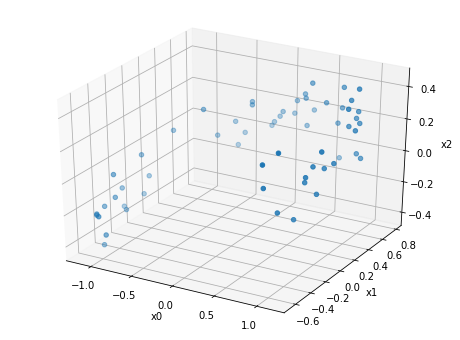

In [2]:
def plot_3d(X3D):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X3D[:, 0], X3D[:, 1], X3D[:, 2])
    ax.set_xlabel('x0')
    ax.set_ylabel('x1')
    ax.set_zlabel('x2')

plot_3d(X)

In [3]:
# Center the data around the origin
X_centered = X - X.mean(axis=0)

# Use singular value decomposition to get first two prin
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [4]:
c1, c2

(array([0.9404593 , 0.28846576, 0.17978825]),
 array([ 0.3253748 , -0.91701452, -0.23068508]))

The principal components can be used to define the hyperplane on which to project the data, thereby reducing the dimensions.

*Equation 2: Projecting the training set down to d dimensions*

\begin{equation*}
\mathbf{X}_{d\text{-proj}} = \mathbf{XW}_d
\end{equation*}

In [5]:
# Define the matrix containing the first 2 principal components
W2 = Vt.T[:, :2]

# Project the data onto W2 to reduce the 3D dataset to 2D
X2D = X_centered.dot(W2)

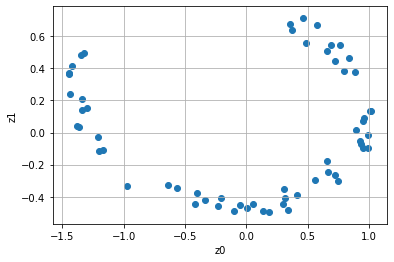

In [6]:
def plot_2d(X2D):
    plt.scatter(X2D[:, 0], X2D[:, 1])
    plt.grid()
    plt.xlabel('z0')
    plt.ylabel('z1')
    
plot_2d(X2D)

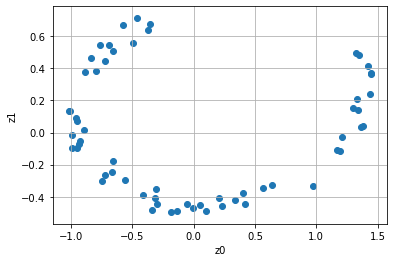

In [7]:
# PCA class can accomplish the same thing
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)
plot_2d(X2D)

In [8]:
# Access the principal components via the components_ attribute
pca.components_

array([[-0.9404593 , -0.28846576, -0.17978825],
       [ 0.3253748 , -0.91701452, -0.23068508]])

In [9]:
# Access the variance ratio of each component
pca.explained_variance_ratio_

array([0.82726304, 0.15983315])

- 86.4% of the dataset's variance lies along $\mathbf{c}_1$
- 12.8% of the variance lies along $\mathbf{c}_2$

One common technique for choosing the right number of dimensions is to determine those that make up a significant portion of the variance in the dataset. If visualization is desired, the number of dimensions should be at most 3.

In [11]:
# Fetch mnist dataset
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [12]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [14]:
pca = PCA()
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [20]:
# Get cumulative sum of variance for all dimensions
cumsum = np.cumsum(pca.explained_variance_ratio_)

# Determine the number of dimensions needed to achieve 95% of the variance
d = np.argmax(cumsum >= 0.95) + 1
d

154

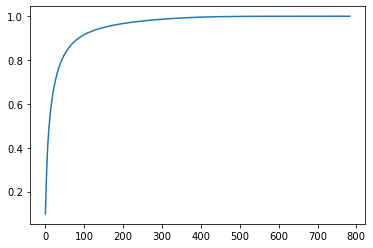

In [28]:
plt.plot(cumsum)

In [22]:
# Recreate the PCA using 154 dimensions
pca = PCA(n_components=d)
X_reduced = pca.fit_transform(X_train)

In [24]:
pca.n_components_, np.sum(pca.explained_variance_ratio_)

(154, 0.9500003626478518)

In [30]:
# n_components also takes a ratio
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [26]:
pca.n_components_, np.sum(pca.explained_variance_ratio_)

(154, 0.9503950315829169)

The reduced dataset may be decompressed to the original dimensionality by applying the inverse transformation. The recovered dataset will have lost the amount of information dropped during reduction, but should be reasonably close to the original.

In [41]:
X_recovered = pca.inverse_transform(X_reduced)

In [34]:
import matplotlib as mpl

# Helper function to plot mnist samples
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

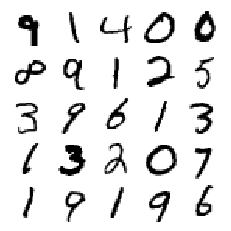

In [40]:
# Original dataset
plot_digits(X_train[::2100], 5)

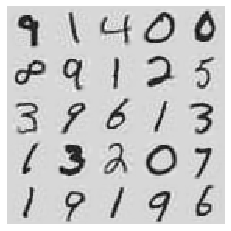

In [42]:
# Compressed dataset
plot_digits(X_recovered[::2100], 5)

*Equation 3: PCA inverse transformation*

\begin{equation*}
\mathbf{X}_\text{recovered} = \mathbf{X}_{d\text{-proj}} \mathbf{W}_d^\mathsf{T}
\end{equation*}

**Randomized PCA** uses a stochastic algorithm to approximate the first $d$ principal components, and is much faster than the full SVD algorithm.

- Standard PCA complexity: $O(m \times n^2) + O(n^3)$
- Randomized PCA complexity: $O(m \times d^2) + O(d^3)$

In [45]:
# If d < 80% of m or n, the randomized solver will be chosen by default
rnd_pca = PCA(n_components=d, svd_solver='randomized')
X_reduced = rnd_pca.fit_transform(X_train)

**Incremental PCA** allows iterative training on batches of data, enabling parallel and online training.

In [46]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=d)

# Split the training set into 100 batches, train the PCA on each
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

Memory mapping may also be used.

In [47]:
# Create the memory map file
m, n = X_train.shape
X_mm = np.memmap('datasets/mnist_map.data', dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

In [48]:
del X_mm

In [49]:
# Map the file to memory
X_mm = np.memmap('datasets/mnist_map.data', dtype='float32', mode='readonly', shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=d, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, copy=True, n_components=154, whiten=False)